In [5]:
from tensorflow import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras import constraints
import tensorflow as tf
import zipfile
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

emnist_labels = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]


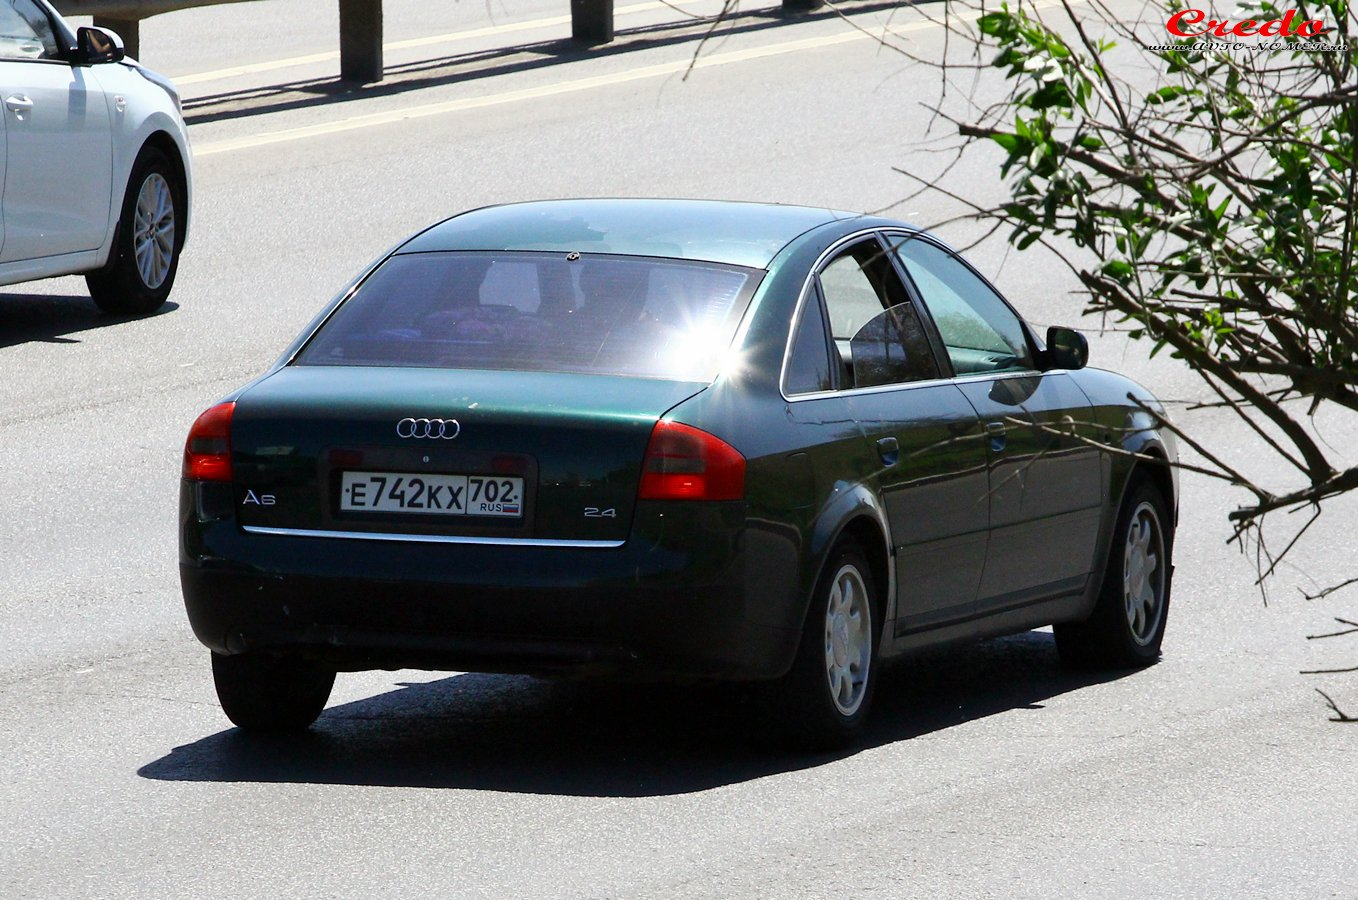

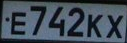

In [6]:
# название файла поменять
img = cv2.imread('/content/4.jpeg')
cv2_imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # переводим в градации серого
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2) # устанавливаем порог для дальнейшего определения контура номерного знака
contours,h = cv2.findContours(thresh,1,2) # находим контуры
largest_rectangle = [0,0]
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
    if len(approx)==4: # В нашем примере мы делаем допущение, что номерной знак - четырехугольник.
        area = cv2.contourArea(cnt)
        if area > largest_rectangle[0]:
            largest_rectangle = [cv2.contourArea(cnt), cnt, approx]

x,y,w,h = cv2.boundingRect(largest_rectangle[1])
vehicle_num=img[y:y+h,x:x+w] # оставляем на исходном изображении только номер автомобиля
cv2_imshow(vehicle_num)

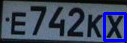

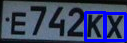

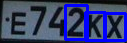

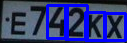

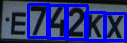

Выводим каждый символ отдельно, отсортировав по координате Х


In [7]:
gray = cv2.cvtColor(vehicle_num, cv2.COLOR_BGR2GRAY) # уже работаем с выделенным участком изображения
ret, thresh = cv2.threshold(gray, 75, 255, cv2.THRESH_BINARY)
img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1) # размываем границы объекта
contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # находим контуры, используя иерархическую структуру
output = vehicle_num.copy()
letters = []
for idx, contour in enumerate(contours):
  (x, y, w, h) = cv2.boundingRect(contour)
  if w > 10 and h > 10:
    if hierarchy[0][idx][3] == 0:
      cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)
      letter_crop = gray[y:y + h, x:x + w]
      cv2_imshow(output)
      size_max = max(w, h) # выделяем область в виде квадрата
      letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
      if w > h:
        y_pos = size_max//2 - h//2
        letter_square[y_pos:y_pos + h, 0:w] = letter_crop
      elif w < h:
        x_pos = size_max//2 - w//2
        letter_square[0:h, x_pos:x_pos + w] = letter_crop
      else:
        letter_square = letter_crop
      out_size = 28  # устанавливаем размеры результирующего изображения для каждой буквы
      letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))
letters.sort(key=lambda x: x[0], reverse=False) # сортируем относительно координаты Х
print("Выводим каждый символ отдельно, отсортировав по координате Х")
for i in range(0,len(letters)):
  cv2_imshow(letters[i][2])

In [8]:
!gdown --id 1tLZ_bMsyjRTKjessSL0ljOAscPp6Tw-T

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tLZ_bMsyjRTKjessSL0ljOAscPp6Tw-T
To: /content/emnist_symbols.h5
100% 57.3M/57.3M [00:01<00:00, 31.3MB/s]


In [9]:
model = keras.models.load_model('/content/emnist_symbols.h5')

In [10]:
def emnist_predict_img(model, img):
    img_arr = np.expand_dims(img, axis=0)
    img_arr = 1 - img_arr/255.0
    img_arr[0] = np.rot90(img_arr[0], 3)
    img_arr[0] = np.fliplr(img_arr[0])
    img_arr = img_arr.reshape((1, 28, 28, 1))
    result = np.argmax(model.predict([img_arr]), axis=1)
    return chr(emnist_labels[result[0]])


In [11]:
def img_to_str(model, letters):
    result = ""
    for i in range(len(letters)):
        dn = letters[i+1][0] - letters[i][0] - letters[i][1] if i < len(letters) - 1 else 0
        cv2_imshow(letters[i][2])
        result += emnist_predict_img(model, letters[i][2])
        if (dn > letters[i][1]/4):
            result += ' '
    return result

In [13]:
result = img_to_str(model, letters)
print(result.replace(' ', '').lower())

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
qa888
